#### Ref : https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_refit_callable.html#sphx-glr-auto-examples-model-selection-plot-grid-search-refit-callable-py

#### Author: Wenhao Zhang <wenhaoz@ucla.edu>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [2]:
#read and sample the data

# check multiple samples, and see class imbalance

data = pd.read_csv('signal-data.csv')
print(data.shape)
data.sample(10)

(1567, 592)


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
1066,2008-09-24 16:26:00,3054.95,2531.78,2178.5889,1135.3544,0.8614,100.0,103.7022,0.1205,1.3499,...,NaN,0.4962,0.0129,0.0032,2.5926,0.0412,0.0176,0.0060,42.6972,-1
1172,2008-09-29 07:53:00,3044.34,2585.92,2241.1778,1521.1987,1.3349,100.0,98.5900,0.1217,1.4306,...,NaN,0.5067,0.0116,0.0029,2.2813,0.1028,0.0233,0.0064,22.6231,-1
597,2008-08-30 20:53:00,2907.52,2547.13,2159.0556,1084.3779,0.8184,100.0,100.7056,0.1249,1.4043,...,NaN,0.5005,0.0155,0.0036,3.1057,0.0256,0.0189,0.0060,73.8657,-1
831,2008-09-13 20:06:00,2961.04,2506.43,2170.0666,1364.5157,1.5447,100.0,96.7700,0.1230,1.3953,...,NaN,0.4994,0.0115,0.0031,2.3020,0.0545,0.0184,0.0055,33.7876,1
1385,2008-07-10 03:39:00,2975.87,2514.44,2206.4000,982.5452,1.1853,100.0,116.8167,0.1228,1.3657,...,NaN,0.4982,0.0079,0.0026,1.5853,0.0295,0.0154,0.0045,52.2049,-1
1099,2008-09-26 05:32:00,3160.54,2304.83,2233.6334,1962.0026,1.2120,100.0,99.0133,0.1222,1.4381,...,NaN,0.4981,0.0142,0.0035,2.8606,0.0179,0.0079,0.0024,44.1194,-1
599,2008-08-30 23:51:00,2895.71,2573.59,2173.6444,1458.7176,0.8811,100.0,101.5667,0.1258,1.5477,...,NaN,0.5018,0.0101,0.0028,2.0162,0.0256,0.0189,0.0060,73.8657,-1
439,2008-08-23 13:02:00,3062.54,2370.50,2177.0222,1448.8499,1.5565,100.0,103.2567,0.1232,1.5533,...,NaN,0.5014,0.0109,0.0029,2.1794,0.0329,0.0055,0.0022,16.6695,-1
555,2008-08-30 02:08:00,2983.83,2413.65,2235.0556,1302.6607,1.6347,100.0,109.9856,0.1230,1.5828,...,NaN,0.5008,0.0127,0.0040,2.5286,0.0335,0.0122,0.0040,36.2970,-1
1421,2008-08-10 12:11:00,2939.57,2564.93,2205.5000,1287.3538,2.3842,100.0,111.7644,0.1241,1.5823,...,NaN,0.4983,0.0157,0.0036,3.1439,0.0299,0.0071,0.0020,23.6431,-1


In [3]:
# Just for demo purpose/ build a quick dirty model, can we drop na ?
data.isna().sum().sort_values(ascending=False)

158          1429
292          1429
293          1429
157          1429
85           1341
             ... 
386             0
361             0
360             0
359             0
Pass/Fail       0
Length: 592, dtype: int64

In [4]:
y = data['Pass/Fail']
X = data.drop(columns=['Time', 'Pass/Fail'])

In [5]:
#Very basic imputation, better way ?
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X)
X = imputer.transform(X)
print(X.shape)

(1567, 590)


In [6]:
def lower_bound(cv_results):
    """
    Calculate the lower bound within 1 standard deviation
    of the best `mean_test_scores`.

    Parameters
    ----------
    cv_results : dict of numpy(masked) ndarrays
        See attribute cv_results_ of `GridSearchCV`

    Returns
    -------
    float
        Lower bound within 1 standard deviation of the
        best `mean_test_score`.
    """
    best_score_idx = np.argmax(cv_results['mean_test_score'])

    return (cv_results['mean_test_score'][best_score_idx]
            - cv_results['std_test_score'][best_score_idx])


def best_low_complexity(cv_results):
    """
    Balance model complexity with cross-validated score.

    Parameters
    ----------
    cv_results : dict of numpy(masked) ndarrays
        See attribute cv_results_ of `GridSearchCV`.

    Return
    ------
    int
        Index of a model that has the fewest PCA components
        while has its test score within 1 standard deviation of the best
        `mean_test_score`.
    """
    threshold = lower_bound(cv_results)
    candidate_idx = np.flatnonzero(cv_results['mean_test_score'] >= threshold)
    best_idx = candidate_idx[cv_results['param_reduce_dim__n_components']
                             [candidate_idx].argmin()]
    return best_idx

In [7]:
pipe = Pipeline([
        ('reduce_dim', PCA()),
        ('classify', DecisionTreeClassifier()), #KNeighborsClassifier(n_neighbors=3)
])

param_grid = {
    'reduce_dim__n_components': [2, 4, 6, 8, 10, 12, 14]
}

### Issue with general Split ??

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(y_train.value_counts())
print(y_test.value_counts())

print("\nTrain set class ratio : ", round(y_train.value_counts()[1]/y_train.value_counts()[-1],2))
print("\nTest set class ratio : ", round(y_test.value_counts()[1]/y_test.value_counts()[-1],2))

-1    1172
 1      81
Name: Pass/Fail, dtype: int64
-1    291
 1     23
Name: Pass/Fail, dtype: int64

Train set class ratio :  0.07

Test set class ratio :  0.08


### Solve Class Imbalance

In [9]:
#Ref : https://scikit-learn.org/stable/modules/cross_validation.html#stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print(y_train.value_counts())
print(y_test.value_counts())
print("\nTrain set class ratio : ", round(y_train.value_counts()[1]/y_train.value_counts()[-1],2))
print("\nTest set class ratio : ", round(y_test.value_counts()[1]/y_test.value_counts()[-1],2))

-1    1170
 1      83
Name: Pass/Fail, dtype: int64
-1    293
 1     21
Name: Pass/Fail, dtype: int64

Train set class ratio :  0.07

Test set class ratio :  0.07


In [10]:
#stratified CV would be better ?

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid,
                    scoring='f1_weighted', refit=best_low_complexity)
grid.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('reduce_dim', PCA()),
                                       ('classify', DecisionTreeClassifier())]),
             n_jobs=1,
             param_grid={'reduce_dim__n_components': [2, 4, 6, 8, 10, 12, 14]},
             refit=<function best_low_complexity at 0x7f9e60371700>,
             scoring='f1_weighted')

In [11]:
grid.cv_results_

{'mean_fit_time': array([0.0259773 , 0.03159754, 0.02691801, 0.03406658, 0.03378882,
        0.03571198, 0.03848352]),
 'std_fit_time': array([0.0052054 , 0.00284294, 0.00236228, 0.00379484, 0.00309856,
        0.00127865, 0.00192479]),
 'mean_score_time': array([0.00172939, 0.00172803, 0.00140669, 0.00157051, 0.00131831,
        0.00132024, 0.00134158]),
 'std_score_time': array([2.07759958e-04, 1.87962242e-04, 7.46422624e-05, 2.50825361e-04,
        7.40508456e-05, 4.48979915e-05, 4.98472757e-05]),
 'param_reduce_dim__n_components': masked_array(data=[2, 4, 6, 8, 10, 12, 14],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'reduce_dim__n_components': 2},
  {'reduce_dim__n_components': 4},
  {'reduce_dim__n_components': 6},
  {'reduce_dim__n_components': 8},
  {'reduce_dim__n_components': 10},
  {'reduce_dim__n_components': 12},
  {'reduce_dim__n_components': 14}],
 'split0_test_score': array([0.844

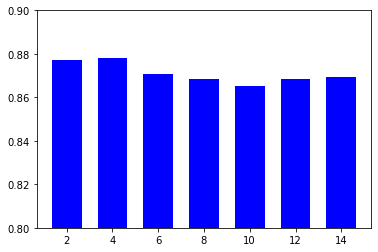

In [12]:
n_components = grid.cv_results_['param_reduce_dim__n_components']
test_scores = grid.cv_results_['mean_test_score']

plt.figure()
plt.ylim((0.8, 0.9))
plt.bar(n_components, test_scores, width=1.3, color='b')

lower = lower_bound(grid.cv_results_)

<BarContainer object of 7 artists>

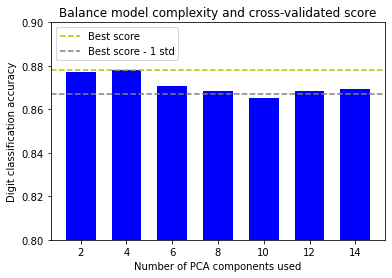

In [13]:
plt.axhline(np.max(test_scores), linestyle='--', color='y',
            label='Best score')
plt.axhline(lower, linestyle='--', color='.5', label='Best score - 1 std')

plt.title("Balance model complexity and cross-validated score")
plt.xlabel('Number of PCA components used')
plt.ylabel('Digit classification accuracy')
plt.xticks(n_components.tolist())
plt.ylim((0.8, 0.9))
plt.legend(loc='upper left')

plt.bar(n_components, test_scores, width=1.3, color='b')